# Capstone 3: Step 4 - Pre-processing and Training Data Development

### **The Data Science Method**  


1.   Problem Identification 

2.   Data Wrangling 
  
3.   Exploratory Data Analysis 
 
4.   **Pre-processing and Training Data Development**

5.  Modeling
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
# print the current working directory
print(os.getcwd())

C:\Users\Nancy\Documents\GitHub\Springboard\Capstone 3 elementary OS revenue projection


In [38]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

In [2]:
pd.set_option('display.max_columns',None)

## Load the data

In [3]:
df=pd.read_csv('data\step2_output.csv')

C:\Users\Nancy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# change the Created (UTC) to a datetime object
df['Created (UTC)']=pd.to_datetime(df['Created (UTC)'])

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Amount,67511.0,6.009428,6.673728,1.00,1.00,5.00,10.00,340.00
Fee,67511.0,0.493294,0.225631,0.01,0.34,0.45,0.59,13.56
Destination Platform Fee,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Net,67511.0,5.516133,6.455838,0.66,0.67,4.55,9.31,326.44
Customer Facing Amount,67511.0,6.009428,6.673728,1.00,1.00,5.00,10.00,340.00
Transfer Group,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# only use data through the end of June 2020
mask = (df['Created (UTC)'] < '2020-7-1')
dfkeep = df.loc[mask]

## Create dataframe indexed by date

In [7]:
dfsum = dfkeep.groupby([dfkeep['Created (UTC)'].dt.date])[['Amount']].sum()

In [8]:
print(dfsum.head())
print(dfsum.tail())

               Amount
Created (UTC)        
2016-03-01       5.00
2016-03-02      56.50
2016-03-03     185.69
2016-03-04     156.99
2016-03-05     143.00
               Amount
Created (UTC)        
2020-06-26     296.41
2020-06-27     412.17
2020-06-28     273.18
2020-06-29     189.04
2020-06-30     300.97


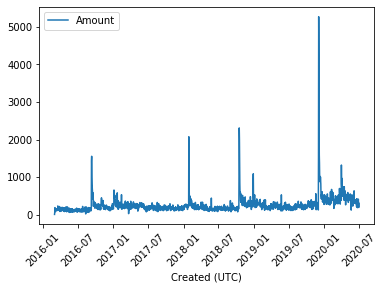

In [9]:
# plot the time series
dfsum.plot(rot=45)

# Capstone 3: Step 5 - Modeling

In [10]:
# instantiate Prophet model
model1=Prophet(interval_width=0.95) # by default is 80%

In [11]:
# reformat data to match Prophet requirements
dfmodel = dfsum
dfmodel.columns=['y_orig']
dfmodel['ds']=dfmodel.index
dfmodel.head()

,y_orig,ds
Created (UTC),,
2016-03-01,5.00,2016-03-01
2016-03-02,56.50,2016-03-02
2016-03-03,185.69,2016-03-03
2016-03-04,156.99,2016-03-04
2016-03-05,143.00,2016-03-05


In [12]:
# log transform the y variable to try to convert from non-stationary to stationary
dfmodel['y']=np.log(dfmodel['y_orig'])

In [13]:
# Split data between train and test
split=int(len(dfmodel) * 0.8) 
# Make train and test variables, with 'train, test'
train, test = dfmodel[0:split], dfmodel[split:len(dfmodel)]

# fit Prophet model with training data
model1.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### 2d. Making a predictor variable `y`

In [14]:
print(dfsum.info())
y = dfmodel['y']

<class 'pandas.core.frame.DataFrame'>
Index: 1583 entries, 2016-03-01 to 2020-06-30
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_orig  1583 non-null   float64
 1   ds      1583 non-null   object 
 2   y       1583 non-null   float64
dtypes: float64(2), object(1)
memory usage: 49.5+ KB
None


Check the type of our new variable. 

In [15]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [16]:
dfsum.describe().T

,count,mean,std,min,25%,50%,75%,max
y_orig,1583.0,253.316639,240.694325,5.000000,153.260000,205.00000,282.000000,5270.060000
y,1583.0,5.364051,0.531319,1.609438,5.032135,5.32301,5.641907,8.569797


### 2f. Plotting `y`

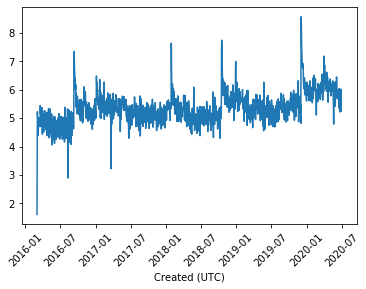

In [17]:
y.plot(rot=45)

## 3. Modelling

C:\Users\Nancy\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


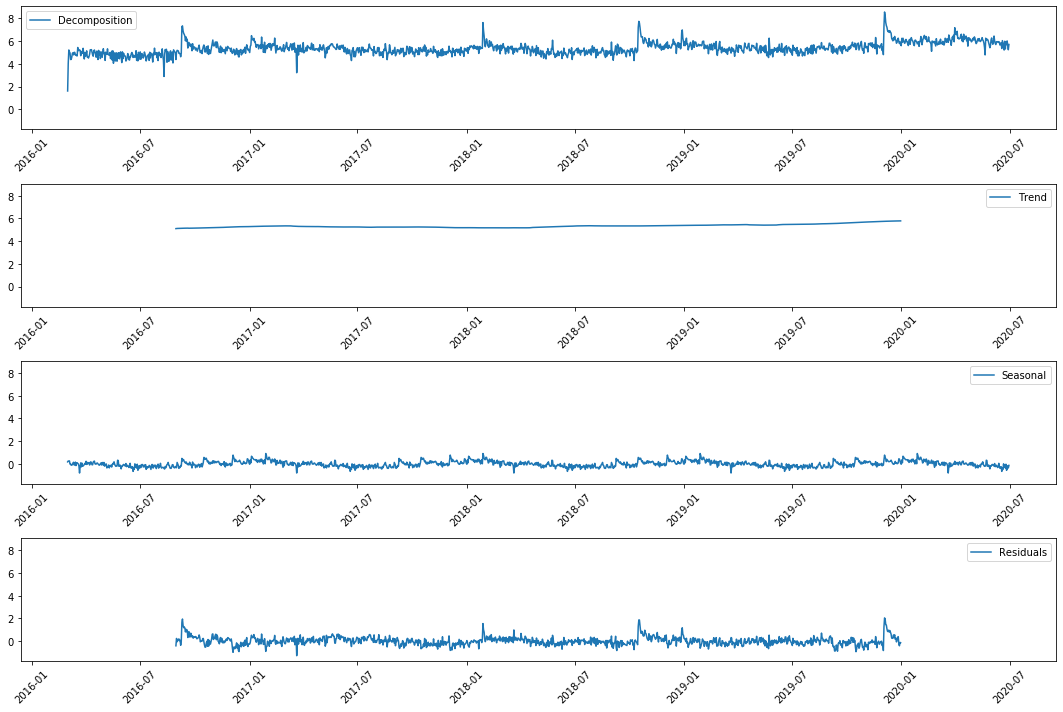

In [18]:
# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y,freq=365)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(15,10))
ax1=plt.subplot(411)
plt.plot(y, label = 'Decomposition')
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.legend(loc = 'best')
ax2=plt.subplot(412, sharex=ax1,sharey=ax1)
plt.plot(trend, label = 'Trend')
plt.setp(ax2.get_xticklabels(), rotation=45)
plt.legend(loc = 'best')
ax3=plt.subplot(413, sharex=ax1,sharey=ax1)
plt.plot(seasonal, label = 'Seasonal')
plt.setp(ax3.get_xticklabels(), rotation=45)
plt.legend(loc = 'best')
ax4=plt.subplot(414, sharex=ax1,sharey=ax1)
plt.plot(residual, label = 'Residuals')
plt.setp(ax4.get_xticklabels(), rotation=45)
plt.legend(loc = 'best')
plt.tight_layout()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [19]:
kpss(y)

C:\Users\Nancy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\Nancy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(2.5646430319522593,
 0.01,
 24,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 

In [20]:
y_log = np.log(y)

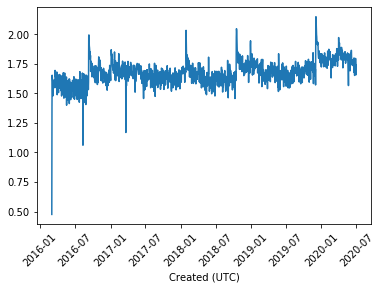

In [21]:
y_log.plot(rot=45)

In [22]:
# difference the data to get a constant mean
kpss_res=kpss(y_log.diff().dropna())
print(kpss_res)

(0.2273286474798981, 0.1, 24, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\Nancy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\Nancy\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


The p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

#### 3di. Make a function to find the MSE of a single ARIMA model

In [23]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [24]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    print('%s ARIMA%s MSE=%.3f' % (str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')),order,mse))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [25]:
# Now, we choose a couple of values to try for each parameter.
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [26]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!

warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

2020-08-28 18:29:25 ARIMA(0, 0, 0) MSE=0.017
2020-08-28 18:30:04 ARIMA(0, 0, 1) MSE=0.010
2020-08-28 18:31:12 ARIMA(0, 0, 2) MSE=0.007
2020-08-28 18:31:19 ARIMA(0, 1, 0) MSE=0.004
2020-08-28 18:32:30 ARIMA(0, 1, 1) MSE=0.003
2020-08-28 18:35:51 ARIMA(0, 1, 2) MSE=0.003
2020-08-28 18:35:56 ARIMA(0, 2, 0) MSE=0.011
2020-08-28 18:40:16 ARIMA(0, 2, 1) MSE=0.004
2020-08-28 18:52:24 ARIMA(0, 2, 2) MSE=0.003
2020-08-28 18:53:01 ARIMA(1, 0, 0) MSE=0.005
2020-08-28 18:56:30 ARIMA(1, 0, 1) MSE=0.003
2020-08-28 19:00:34 ARIMA(1, 0, 2) MSE=0.003
2020-08-28 19:01:13 ARIMA(1, 1, 0) MSE=0.004
2020-08-28 19:06:20 ARIMA(1, 1, 1) MSE=0.003
2020-08-28 19:15:31 ARIMA(1, 1, 2) MSE=0.003
2020-08-28 19:16:08 ARIMA(1, 2, 0) MSE=0.007
2020-08-28 19:17:12 ARIMA(2, 0, 0) MSE=0.004
2020-08-28 19:22:05 ARIMA(2, 0, 1) MSE=0.003
2020-08-28 19:30:58 ARIMA(2, 0, 2) MSE=0.003
2020-08-28 19:32:21 ARIMA(2, 1, 0) MSE=0.003
2020-08-28 19:40:59 ARIMA(2, 1, 1) MSE=0.003
2020-08-28 19:54:49 ARIMA(2, 1, 2) MSE=0.003
2020-08-28

In [27]:
p=2
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(730)

We can take a look at a summary of the model this library has built around our data.

In [28]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1582
Model:                 ARIMA(2, 1, 1)   Log Likelihood                2008.231
Method:                       css-mle   S.D. of innovations              0.068
Date:                Fri, 28 Aug 2020   AIC                          -4006.462
Time:                        19:57:23   BIC                          -3979.630
Sample:                    03-02-2016   HQIC                         -3996.492
                         - 06-30-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.761      0.447      -0.000       0.001
ar.L1.D.y      0.2443      0.039      6.281      0.000       0.168       0.321
ar.L2.D.y      0.0552      0.035      1.595      0.111      -0.013       0.123
ma.L1.D.y     -0.8706      0.027    -32.470      0.000      -0.923      -0.818
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5845           +0.0000j            2.5845            0.0000
AR.2           -7.0123           +0.0000j            7.0123            0.5000
MA.1            1.1487           +0.0000j            1.1487            0.0000
-----------------------------------------------------------------------------
"""

In [44]:
# show model results
print('explained variance score: ',explained_variance_score(y_log[1:], model_fit.predict()))
print('MAE: ',mean_absolute_error(y_log[1:], model_fit.predict()))
print('R2 score is: ',r2_score(y_log[1:], model_fit.predict()))

explained variance score:  -0.3263541004611714
MAE:  1.6760290448086197
R2 score is:  -306.8386569321416


In [43]:
y_log[1:]

Created (UTC)
2016-03-02    1.394818
2016-03-03    1.653278
2016-03-04    1.620612
2016-03-05    1.601979
2016-03-06    1.477511
                ...   
2020-06-26    1.739017
2020-06-27    1.795326
2020-06-28    1.724574
2020-06-29    1.656695
2020-06-30    1.741695
Name: y, Length: 1582, dtype: float64

In [36]:
y_log

Created (UTC)
2016-03-01    0.475885
2016-03-02    1.394818
2016-03-03    1.653278
2016-03-04    1.620612
2016-03-05    1.601979
                ...   
2020-06-26    1.739017
2020-06-27    1.795326
2020-06-28    1.724574
2020-06-29    1.656695
2020-06-30    1.741695
Name: y, Length: 1583, dtype: float64

In [35]:
model_fit.predict()

2016-03-02    0.000242
2016-03-03   -0.364407
2016-03-04   -0.343886
2016-03-05   -0.235917
2016-03-06   -0.181347
                ...   
2020-06-26   -0.030407
2020-06-27    0.008914
2020-06-28   -0.029874
2020-06-29    0.021577
2020-06-30    0.057558
Freq: D, Length: 1582, dtype: float64

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

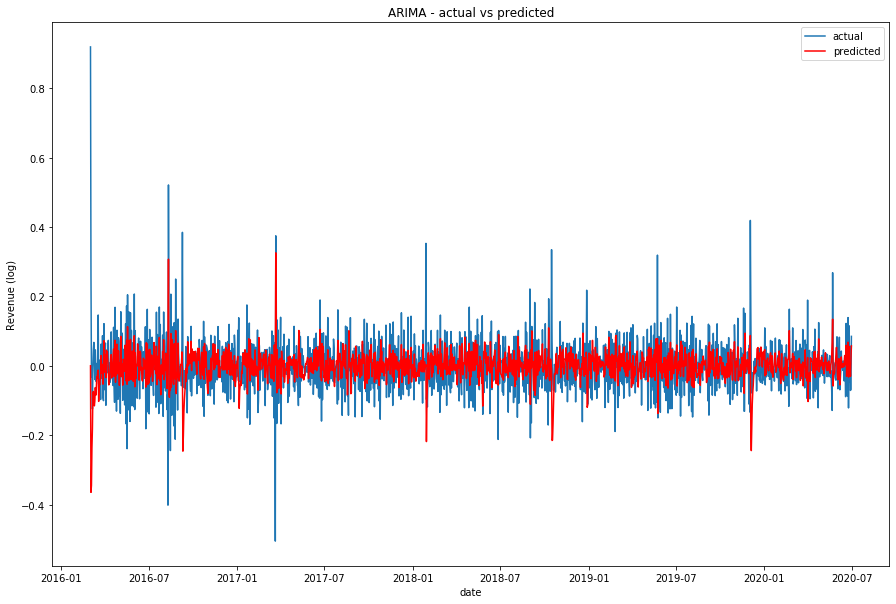

In [46]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
plt.plot(y_log.diff().dropna(), label="actual")
plt.plot(model_fit.predict(), color = 'red', label="predicted")
plt.ylabel('Revenue (log)')
plt.xlabel('date')
plt.title('ARIMA - actual vs predicted')
plt.legend(loc="upper right")
plt.savefig('figures/fig8 ARIMA results.png')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [30]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 730
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='D').strftime("%Y-%m-%d").tolist()

# Convert that range into a dataframe that includes your predictions
# First, call DataFrame on pd
future_dates = pd.DataFrame(date_range, columns = ['Date'])
# Let's now convert the 'Date' column to a datetime object with to_datetime 
future_dates['Date'] = pd.to_datetime(future_dates['Date'])
future_dates.set_index('Date', inplace = True)
future_dates['Prediction'] = forecast[0]

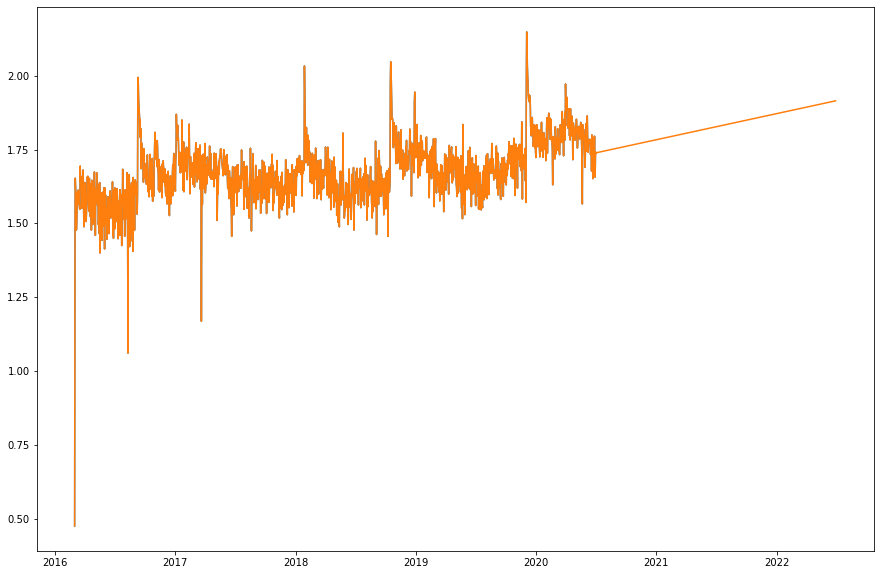

In [31]:
# Plot future predictions
# Call figure() on plt
plt.figure(figsize=(15,10))
plt.plot(y_log)
#plt.plot(y_log['2020-06-30'].append(future_dates['Prediction']))
plt.plot(y_log.append(future_dates['Prediction']))
plt.show()

In [32]:
# predictions are on the log-y, convert predictions back to y
pred = np.exp(future_dates)

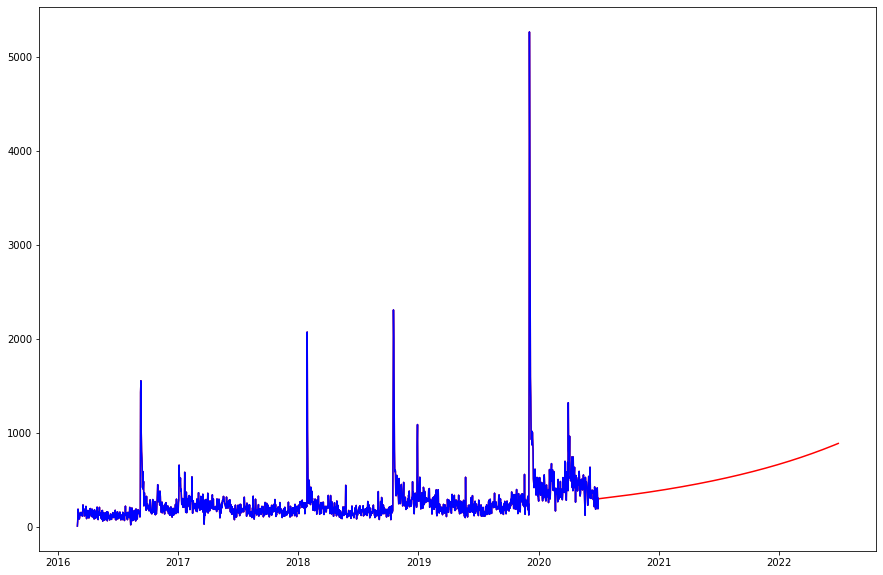

In [33]:
# Now plot the original variable y 
# Use the same functions as before
plt.figure(figsize=(15,10))
plt.plot(np.exp(y.append(pred['Prediction'])),color='red')
plt.plot(dfmodel['y_orig'], color='blue')
plt.show()

In [34]:
dfmodel.y_orig.head(10)

Created (UTC)
2016-03-01      5.00
2016-03-02     56.50
2016-03-03    185.69
2016-03-04    156.99
2016-03-05    143.00
2016-03-06     80.00
2016-03-07     81.00
2016-03-08    100.00
2016-03-09    138.00
2016-03-10    146.00
Name: y_orig, dtype: float64

## 4. Evaluating and Concluding

